In [224]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [225]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

from arch import arch_model

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

### Общие данные, первичный анализ

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot: xlabel='year'>

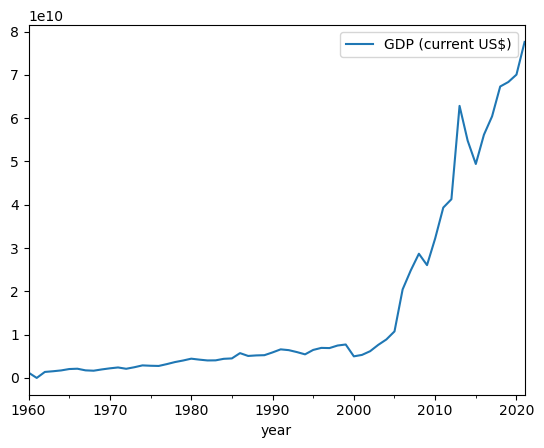

In [226]:
df = pd.read_csv("data/ghana_gdp.csv",parse_dates=['year'], index_col=['year'])
display(df.head())
df.plot()

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


Данные о ВВП Ганы представлены за период в 62 года с 1960 по 2021, также можно выделить явный выброс - в 1961 году отсутсутствует ВВП. Объем ВВП меняется от 1 млрд долларов до 77 млрд. долларов. Из графика видно, что до 2000 года ВВП увеличивался линейно c небольшим коэффицентом, также можно выделить небольшие спады раз в 4-5 лет, после 2000 года начался быстрый рост со спадом в 2009,2014-2015 гг.

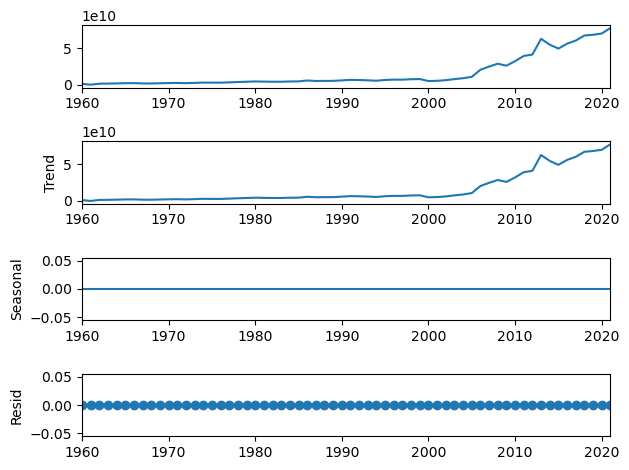

In [228]:
decomposition = seasonal_decompose(df, model='additive') 
decomposition.plot()
plt.show()

Сезонность не выявлена, тренд совпадает с самим графиком.  

Так как выброс находятся в самом начале ряда, удалим первые два значения и раздели м ряд на обучающую и тестовую выборку.

In [229]:
df = df[2:]

split_test = df.index[-3]
split_train = df.index[-4]
train_df = df[:split_train]
test_df = df[split_test:]
print(f'Train shape: {train_df.shape}, test shape: {test_df.shape}')

Train shape: (57, 1), test shape: (3, 1)


### MA Скользящее среднее

Для вычисления скользящего среднего для предсказательного ряда напишем функцию, которая будет вычислять следующее скользящее среднее, учитывая уже вычисленное значение. 

In [230]:
def moving_average_forecast(series, window_size, forecast_steps):
    """
    This function generates forecasts for a time series using a moving average approach. 
    It iteratively extends the input series by predicting one step at a time, based on the average of the last window_size values. 
    
Parameters:
series (pd.Series):  time series data;
window_size (int): size of the window; 
forecast_steps (int): number of steps to forecast.

Returns:
result (pd.Series): forecast_steps values of the extended series. 

    """
    # Создаем копию исходного ряда, чтобы не изменять его
    series_extended = series.copy()
    
    # Выполняем прогнозирование по каждому шагу
    for _ in range(forecast_steps):
        if len(series_extended) >= window_size:
            # Расчет среднего значения для последнего окна
            moving_avg = series_extended[-window_size:].mean()
        else:
            # Если ряд короче окна, просто берем среднее по доступным значениям
            moving_avg = series_extended.mean()
                
        # Добавляем прогноз в конец ряда
        series_extended = series_extended.append(pd.Series([moving_avg]), ignore_index=True)
        result = series_extended[-forecast_steps:]
        result.index = test_df.index
    
    
    return result

Проверим скользящее среднее на окнах размером от 2 до 9, сравнивая по метрике MAPE.

In [231]:
ma_forecast = {'Window':[], 'Forecast':[], 'MAPE':[]}

for window in range(2,10):
    ma_forecast['Window'].append(window)
    
    forecast = moving_average_forecast(train_df['GDP (current US$)'], window, test_df.shape[0])
    ma_forecast['Forecast'].append(forecast)
    
    MAPE = metrics.mean_absolute_percentage_error(test_df, forecast)
    ma_forecast['MAPE'].append(MAPE)
    
    
ma_forecast_df = pd.DataFrame(ma_forecast).set_index('Window')
display(ma_forecast_df)

,Forecast,MAPE
Window,,
2,year 2019-01-01 6.385283e+10 2020-01-01 ...,0.098464
3,year 2019-01-01 6.129028e+10 2020-01-01 ...,0.126888
4,year 2019-01-01 5.831935e+10 2020-01-01 ...,0.162579
5,year 2019-01-01 5.761205e+10 2020-01-01 ...,0.184657
6,year 2019-01-01 5.848055e+10 2020-01-01 ...,0.189640
7,year 2019-01-01 5.602204e+10 2020-01-01 ...,0.203269
8,year 2019-01-01 5.393645e+10 2020-01-01 ...,0.224222
9,year 2019-01-01 5.152098e+10 2020-01-01 ...,0.255899


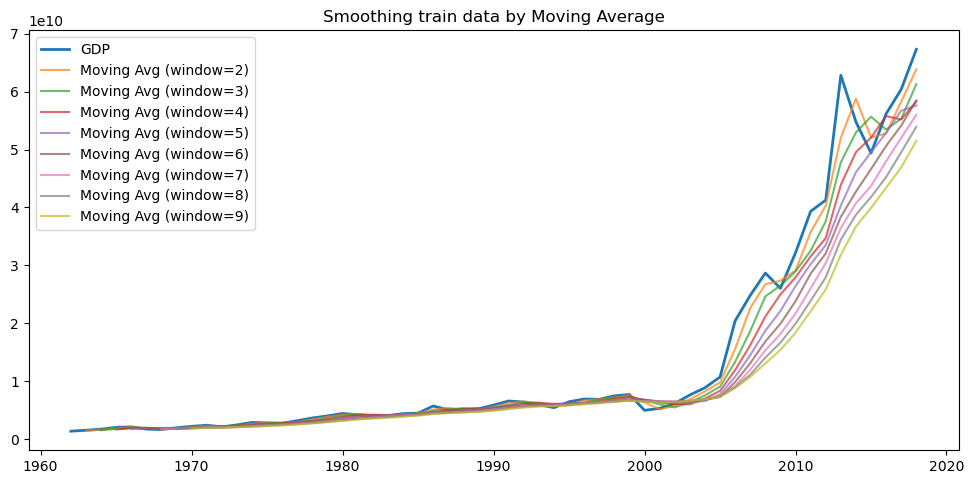

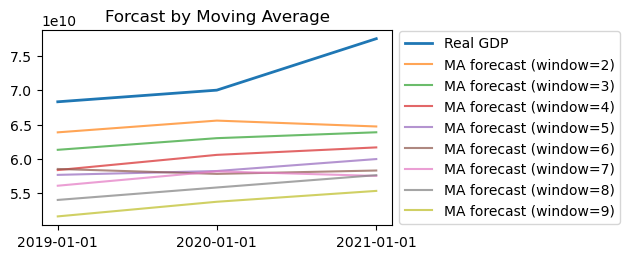

In [232]:
plt.figure(figsize=(12,12))

plt.subplot(2, 1, 1)
plt.plot(train_df['GDP (current US$)'], label='GDP', linewidth=2)

for window in range(2,10):
    plt.plot(train_df['GDP (current US$)'].rolling(window=window).mean(), 
             label=f'Moving Avg (window={window})',
             alpha=0.7
             )

plt.legend()
plt.title('Smoothing train data by Moving Average')

plt.show()


plt.subplot(2, 1, 2)

plt.plot(test_df['GDP (current US$)'], label='Real GDP', linewidth=2)

for window in ma_forecast_df.index:
    plt.plot(ma_forecast_df.loc[window]['Forecast'], 
             label=f'MA forecast (window={window})',
             alpha=0.7
             )
plt.xticks(test_df.index)
plt.title('Forcast by Moving Average')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Лучшая метрика была показана на скользящем среднем с окном равным 2 и составила 9,8%, последующее увеличение окна приводило к увеличению MAPE. Из графика видно, что все предсказанные данные находятся ниже реальных, что легко можно объяснить растущим трендом, т.к. скользящее среднее отражает тот же рост, только смягчая его средним значением за последние года.  
Также можно отметить, что в реальных данных скорость увеличения размера ВВП с 2020 к 2021 году увеличивается, тогда как для большинства предсказаний она подает, кроме предсказаний с размером окна 5, что может говорить, что возможно имеет место быть цикл в 5 лет, по крайней мере для последних лет выборки.

### ARIMA (подбор параметров: стационарность, автокорреляция)

Напишем функцию, которая будет определять уровень достижения стационарности по тесту Дики-Фуллера и строить графики автокорреляции для стационарного ряда.

In [233]:
def adf_test_recursive(series, critical_val='5%', max_diff=10):
    """
    This function performs a recursive Augmented Dickey-Fuller (ADF) test on a time series to determine whether the series is stationary.
    If the series is not stationary, it applies differencing to the series and repeats the test 
    until the series becomes stationary or a maximum number of differences (max_diff) is reached.

    Parameters:
    series (pd.Series): time series;
    critical_val (str, default='5%'): critical value  used to determine stationarity in the ADF test;
    max_diff (int, default=10): max number of differencing steps/ 

    Returns:
    series (pd.Series): differenced series;
    diff_count (int): number of differencing steps;
    adf_result (tuple): result of the final ADF test.
    """
    diff_count = 0
    adf_result = sm.tsa.adfuller(series)
    
    # Рекурсивная дифференциация до тех пор, пока ряд не станет стационарным или пока не достигнем max_diff
    while (adf_result[0] > adf_result[4][critical_val]) and (diff_count < max_diff):
        series = series.diff().dropna()  # Дифференциация ряда и удаление NaN
        diff_count += 1
        adf_result = sm.tsa.adfuller(series)
    
    if diff_count == max_diff:
        print("Warning: max diff")
    
    
    return series, diff_count, adf_result


def adf_acf_pacf(series, critical_val='5%', max_diff=10, lags=20):
    """
    This function prints the ADF test with the plotting of ACF and PACF    
    Parameters:
    series (pd.Series): time series;
    critical_val (str, default='5%' ): critical value used in the ADF test;
    max_diff (int, default=10): max number of differencing steps;
    lags(int, default=20): number of lags for plotting of ACF and PACF.
    """
    result = adf_test_recursive(series, critical_val, max_diff)
    print('ADF test results:')
    print(*result[2], sep='\n')
    print('='*80)
    
    print(f'd={result[1]}')
    print('='*80)
    
    plot_acf(result[0], lags=lags)
    plt.show()
    
    plot_pacf(result[0], lags=lags)
    plt.show()


ADF test results:
-5.316127302818534
5.06980879924223e-06
9
47
{'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
2126.966133975683
d=3


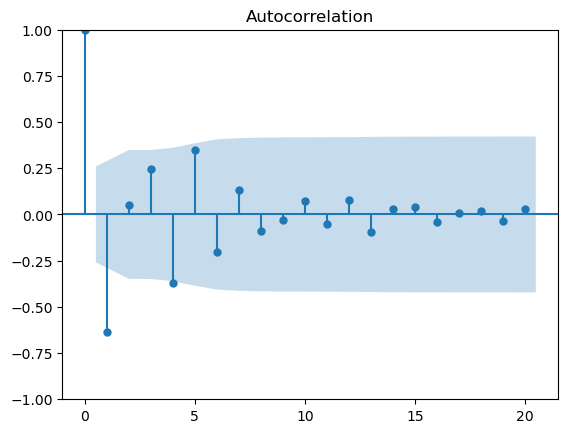

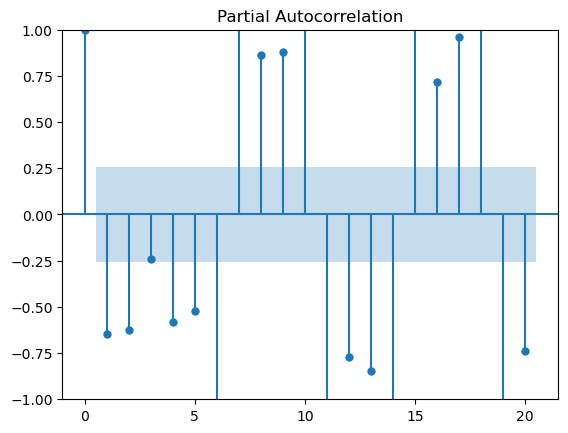

In [234]:
adf_acf_pacf(df)

Стационарность достигнута после трех диффернциаций (d=3), по графику автокорреляции можно предположить, что значения q=[1,4], по графику частичной автокореляции сложно определить, предположим слеующие оптимальные значения для p=[1,2,3,5], так как после 5 лага, начинаются схожие колебания в корреляции. 

Проведем подбор лучшей модели ARIMA перебором выявленных значений, ориентируясь на критерий AIC. 

In [235]:
def find_best_arima(data, p_values, d_values, q_values):
    """
    This function performs a grid search over specified ranges of ARIMA model parameters (p, d, q) to find the best ARIMA model. 
    It evaluates the models based on the Akaike Information Criterion (AIC) and returns the model with the lowest AIC.
    """
    best_aic = float('inf')
    best_order = None
    best_model = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                        
                except:
                    continue
    print(f'Лучшая модель: ARIMA{best_order} с AIC={best_aic}')
    return best_model

In [236]:
p_values = [1,2,3,5]  
d_values = [3]  
q_values = [1,4]

best_model = find_best_arima(train_df, p_values, d_values, q_values)
forecast = best_model.forecast(steps=3)
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print()
print(best_model.summary())

Лучшая модель: ARIMA(5, 3, 4) с AIC=2552.7155101732933
MAPE: 0.06255331675291896

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   57
Model:                 ARIMA(5, 3, 4)   Log Likelihood               -1266.358
Date:                Wed, 02 Oct 2024   AIC                           2552.716
Time:                        00:52:13   BIC                           2572.605
Sample:                    01-01-1962   HQIC                          2560.386
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4220      0.689     -0.612      0.540      -1.773       0.929
ar.L2          0.0073      0.686      0.011      

Лучшая модель по AIC: ARIMA(5, 3, 4) показала AIC=2552.716 и MAPE на тестовом наборе 6.3%.  

Посомотрим результат предсказания на графике.

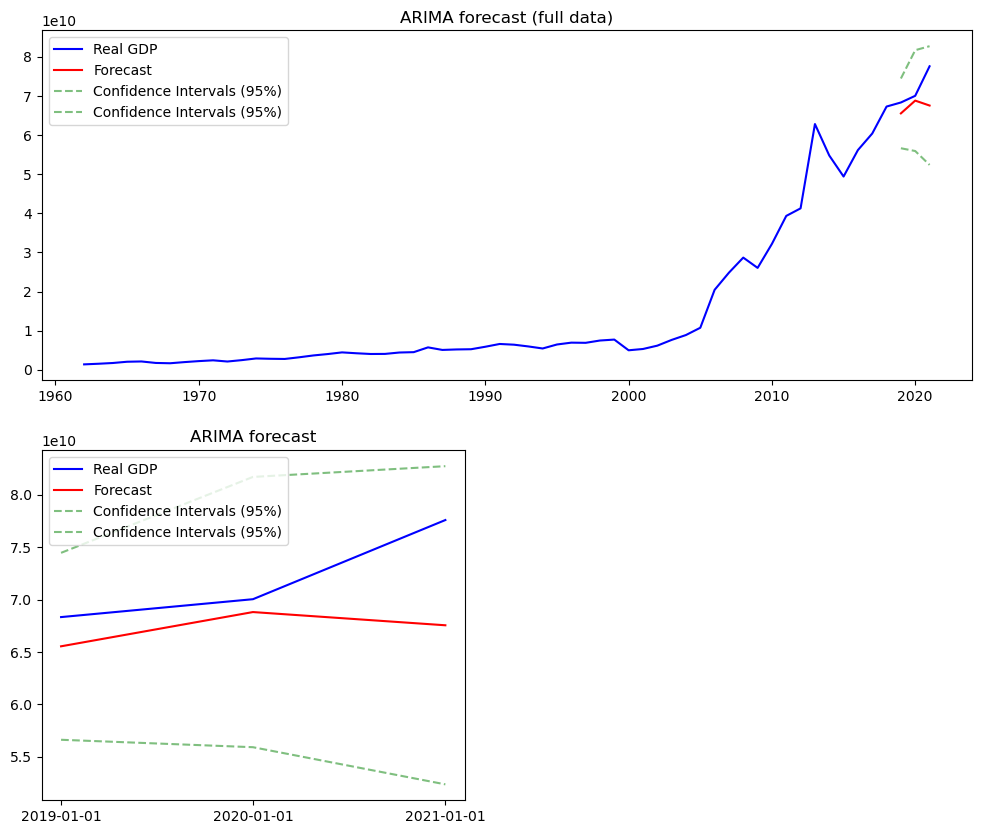

In [237]:
confidence_df = best_model.get_forecast(len(test_df.index)).conf_int(alpha=0.05)  # Confidence level of 95% 

plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)

plt.plot(df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    confidence_df["lower GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    confidence_df["upper GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.title("ARIMA forecast (full data)")
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    confidence_df["lower GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    confidence_df["upper GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("ARIMA forecast")
plt.legend()

plt.show()

Видно, что предсказаннные значения сходятся к 2020 году и расходятся к 2021, так как модель предсказала небольшое падение, а реальные данные показывают рост, все предсказания ниже реальных значений, реальные значения лежат в доверительном интервале (95%).  

Тепреь рассмотрим подбор параметров с помощью ,библиотеки pmdarima.

In [238]:
aa_model = auto_arima(train_df,     
                   start_p=0,         
                   start_q=0,          
                   max_p=10,            
                   max_q=10,
                   d=3,
                   seasonal=False,     
                   trace=False,          
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=False)       


forecast, conf_int = aa_model.predict(n_periods=3, return_conf_int=True, alpha=0.05)
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print()
print(aa_model.summary())


MAPE: 0.080778444357184

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(4, 3, 1)   Log Likelihood               -1271.943
Date:                Wed, 02 Oct 2024   AIC                           2555.886
Time:                        00:52:18   BIC                           2567.820
Sample:                    01-01-1962   HQIC                          2560.489
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9254      0.162     -5.696      0.000      -1.244      -0.607
ar.L2         -0.9252      0.368     -2.514      0.012      -1.646      -0.204
ar.L3         -0.6465      

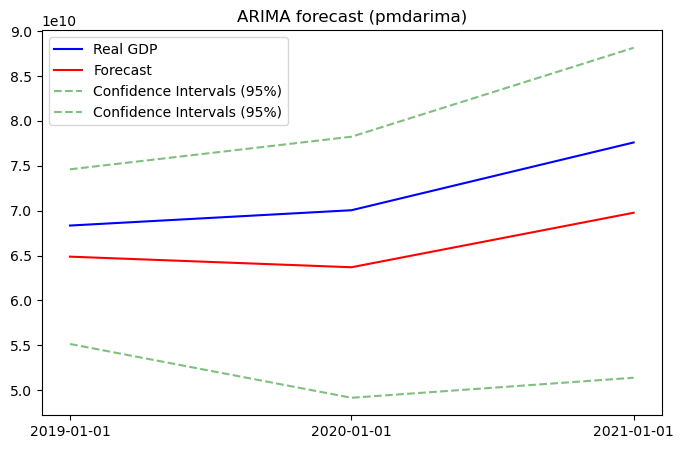

In [239]:
conf_int_df = pd.DataFrame(conf_int, index=test_df.index, columns=['lower_bound', 'upper_bound'])

plt.figure(figsize=(8,5))
plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    conf_int_df["lower_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    conf_int_df["upper_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("ARIMA forecast (pmdarima)")
plt.legend()

plt.show()

Модель подобранная pmdarima: ARIMA(4, 3, 1) показала  чуть выше AIC - 2555.886 и хуже показатель MAPE на тестовой выборке 8,1%, при этои по графику можно заметить, что модель более схожа с реальными данными и учла увеличение скорости роста ВВП в 2021 г. Реальные значения также лежат в доверительном интервале.

Хотя функция seasonal_decompose не показала наличие сезонности и цикличности, в ходе исследования были предположения о наличии цикличности m=[4,5,8,9].  
Проверим метрики для модели SARIMA с такими циклами и автоподбором с помощью библиотеки pmdarima.


In [240]:
for m_ in [4,5,8,9]:
    as_model = auto_arima(train_df,      
                        start_p=0,          
                        start_q=0,          
                        max_p=10,            
                        max_q=10,
                        d=3,
                        m=m_,
                        seasonal=True,      
                        trace=False,          
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)       


    print(f'm={m_}')
    forecast, conf_int = as_model.predict(n_periods=3, return_conf_int=True, alpha=0.05)
    print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
    print(f'AIC:{as_model.aic()}')

m=4
MAPE: 0.10171012240684435
AIC:2549.3830598165396
m=5
MAPE: 0.31406184040333024
AIC:2320.1893142313884
m=8
MAPE: 0.080778444357184
AIC:2555.886204827437
m=9
MAPE: 0.05093995504881737
AIC:2548.6516533153826


Цикл в 5 лет, дал улучшение в AIC, но MAPE больше 30%, можно предположить, что модель хорошо подстроилась под данные до 2000 года, но потом такой цикл плохо подходил к данным.  
Лучший MAPE - 5.1% у модели с 9 летними циклами - SARIMA(2, 3, 2)x(1, 0, [], 9), AIС также незначительно лучше, чем у моделей ARIMA  и составляет 2548.652.

In [241]:
as_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(2, 3, 2)x(1, 0, [], 9)   Log Likelihood               -1268.326
Date:                            Wed, 02 Oct 2024   AIC                           2548.652
Time:                                    00:53:26   BIC                           2560.586
Sample:                                01-01-1962   HQIC                          2553.254
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3087      0.172     -1.797      0.072      -0.645       0.028
ar.L2         -0.1988      0.233     -0.853      0.394      -0.656       0.258
ma.L1         -1.8303      0.142    -12.901      0.000      -2.108      -1.552
ma.L2          0.8536      0.153      5.590      0.000       0.554       1.153
ar.S.L9       -0.4865      0.278     -1.753      0.080      -1.031       0.058
sigma2      1.093e+19   6.91e-20   1.58e+38      0.000    1.09e+19    1.09e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               275.05
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):             247.26   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.42e+55. Standard errors may be unstable.
"""

Подведем предварительный итог и запишем результаты лучших моделей в таблицу.

In [242]:
model_results = [
    {'model':'MA(2)', 'MAPE':0.0985},
    {'model':'ARIMA(5, 3, 4)', 'MAPE':0.0626, 'AIC':2552.716},
    {'model':'ARIMA(4, 3, 1)', 'MAPE':0.0808, 'AIC':2555.886 },
    {'model':'SARIMA(2, 3, 2)x(1, 0, [], 9)', 'MAPE':0.0509, 'AIC':2548.652 }    
    ]

pd.DataFrame(model_results)

,model,MAPE,AIC
0,MA(2),0.0985,NaN
1,"ARIMA(5, 3, 4)",0.0626,2552.716
2,"ARIMA(4, 3, 1)",0.0808,2555.886
3,"SARIMA(2, 3, 2)x(1, 0, [], 9)",0.0509,2548.652


____

### Интерполяция

Проведем интерполяцию данных и посмотрим на результаты метрик и выбора моделей на интерполированных данных.

Из графика было выявлено нулевое значение за 1961 год, проверим остальные данные.

In [243]:
df = pd.read_csv("data/ghana_gdp.csv",parse_dates=['year'], index_col=['year'])

df = df.asfreq('AS')

print('Пропущенные даты:')
df[df['GDP (current US$)'].isnull()]


Пропущенные даты:


,GDP (current US$)
year,


Пропущенные даты  и значения отсутствует.

In [244]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
df.isna().sum()

GDP (current US$)    1
dtype: int64

Имеется одно нулевое значение (1961 г.), заполним его с помощью линейной интерполяции.

In [245]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Теперь с интерполированным рядом проведем те же действтя по подбору модели.

In [246]:
split_test = df.index[-3]
split_train = df.index[-4]
train_df = df[:split_train]
test_df = df[split_test:]
print(f'Train shape: {train_df.shape}, test shape: {test_df.shape}')

Train shape: (59, 1), test shape: (3, 1)


ADF test results:
-4.825603687304036
4.857318076799624e-05
7
48
{'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
2060.4811556595264
d=3


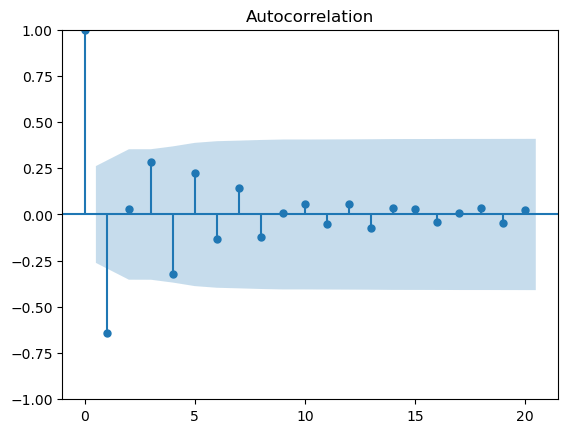

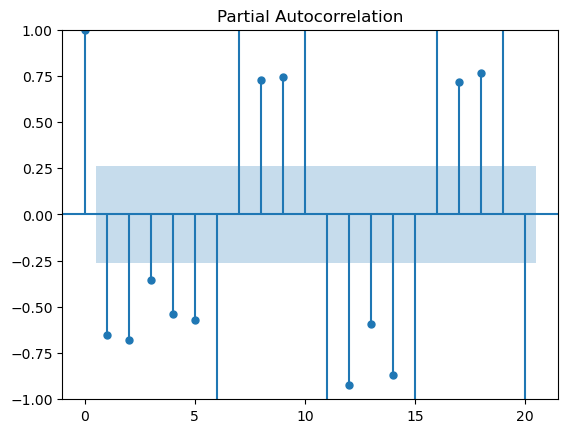

In [247]:
adf_acf_pacf(train_df)

Значения теста Дики Фулера незначительно поменялось, графики тоже несильно поменялись. Проверим модель ARIMA на тех же параметрах.

In [248]:
p_values = [1,2,3,5]  
d_values = [3]  
q_values = [1,4]

best_model = find_best_arima(train_df, p_values, d_values, q_values)
forecast = best_model.forecast(steps=3)
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print()
print(best_model.summary())

Лучшая модель: ARIMA(5, 3, 4) с AIC=2643.8277030640475
MAPE: 0.06378237226309406

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 3, 4)   Log Likelihood               -1311.914
Date:                Wed, 02 Oct 2024   AIC                           2643.828
Time:                        00:53:30   BIC                           2664.081
Sample:                    01-01-1960   HQIC                          2651.680
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4182      0.635     -0.658      0.511      -1.664       0.827
ar.L2          0.0111      0.634      0.018      

Из сформированного набора парметров лучшей оказалась та жа модель - ARIMA(5, 3, 4), но MAPE=0.0638 и AIC=2643.828 ухудшилось, это можно объяснить увеличением выборки на 2 новых значения. Теперь модели сложнее подогнать коэффициенты регрессии и скользящего среднего, зато обобщающие свойства модели должны увеличиваться.

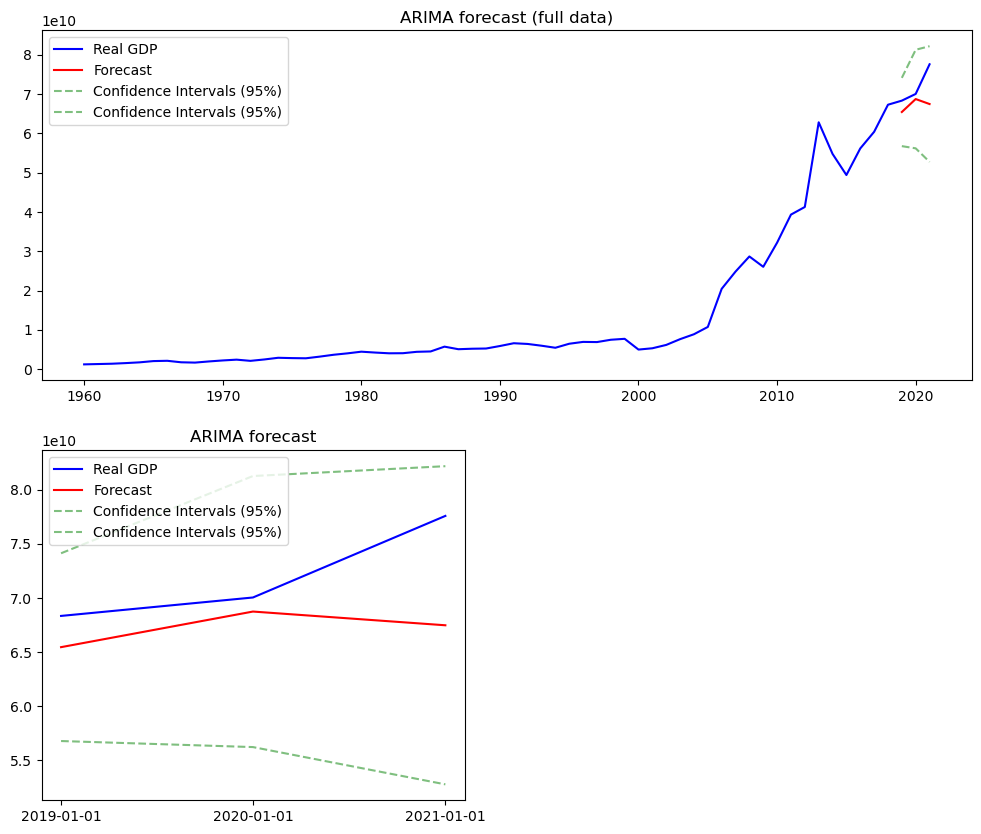

In [249]:
confidence_df = best_model.get_forecast(len(test_df.index)).conf_int(alpha=0.05)  # Confidence level of 95% 

plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)

plt.plot(df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    confidence_df["lower GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    confidence_df["upper GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.title("ARIMA forecast (full data)")
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    confidence_df["lower GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    confidence_df["upper GDP (current US$)"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("ARIMA forecast")
plt.legend()

plt.show()

Подберем параметры с помощью библиотеки pmdarima

In [250]:
aa_model = auto_arima(train_df,     
                   start_p=0,         
                   start_q=0,          
                   max_p=10,            
                   max_q=10,
                   d=3,
                   seasonal=False,     
                   trace=False,          
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=False)       


forecast, conf_int = aa_model.predict(n_periods=3, return_conf_int=True, alpha=0.05)
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print()
print(aa_model.summary())


MAPE: 0.0815309363196418

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(4, 3, 1)   Log Likelihood               -1317.908
Date:                Wed, 02 Oct 2024   AIC                           2647.817
Time:                        00:53:35   BIC                           2659.969
Sample:                    01-01-1960   HQIC                          2652.528
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9263      0.156     -5.952      0.000      -1.231      -0.621
ar.L2         -0.9275      0.352     -2.633      0.008      -1.618      -0.237
ar.L3         -0.6500     

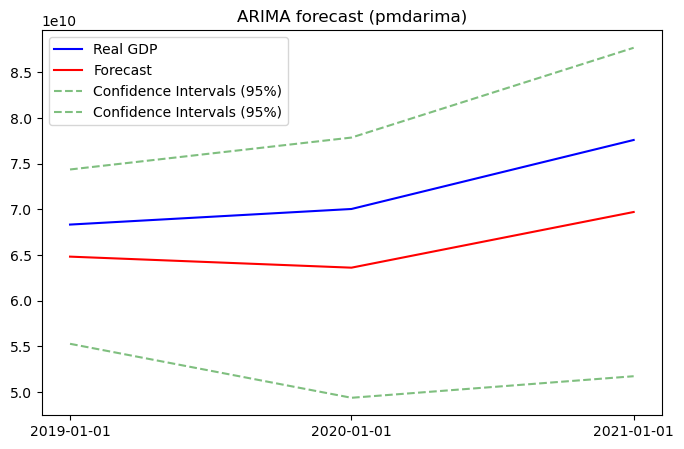

In [251]:
conf_int_df = pd.DataFrame(conf_int, index=test_df.index, columns=['lower_bound', 'upper_bound'])

plt.figure(figsize=(8,5))
plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    conf_int_df["lower_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    conf_int_df["upper_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("ARIMA forecast (pmdarima)")
plt.legend()

plt.show()

Гиперпараметры модели те же - ARIMA(4, 3, 1), также ухудшился AIC=2647.817 и MAPE=0.0815.  

Проверим модель SARIMA с предполагаемыми циклами.

In [252]:
for m_ in [4,5,8,9]:
    as_model = auto_arima(train_df,      
                        start_p=0,          
                        start_q=0,          
                        max_p=10,            
                        max_q=10,
                        d=3,
                        m=m_,
                        seasonal=True,      
                        trace=False,          
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)       


    print(f'm={m_}')
    forecast, conf_int = as_model.predict(n_periods=3, return_conf_int=True, alpha=0.05)
    print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
    print(f'AIC:{as_model.aic()}')

m=4
MAPE: 0.10115027853425256
AIC:2641.225437125163
m=5
MAPE: 0.31334523584687135
AIC:2412.203802990625
m=8
MAPE: 0.0815309363196418
AIC:2647.8169739121613
m=9
MAPE: 0.04933271150127805
AIC:2640.4823894368983


Также по MAPE лучшая модель с циклом в 9 лет

MAPE: 0.04933271150127805

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   59
Model:             SARIMAX(2, 3, 2)x(1, 0, [], 9)   Log Likelihood               -1314.241
Date:                            Wed, 02 Oct 2024   AIC                           2640.482
Time:                                    00:54:46   BIC                           2652.634
Sample:                                01-01-1960   HQIC                          2645.194
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3110      0.165     -1.889      0.059      -0.634       0.012
ar.L2   

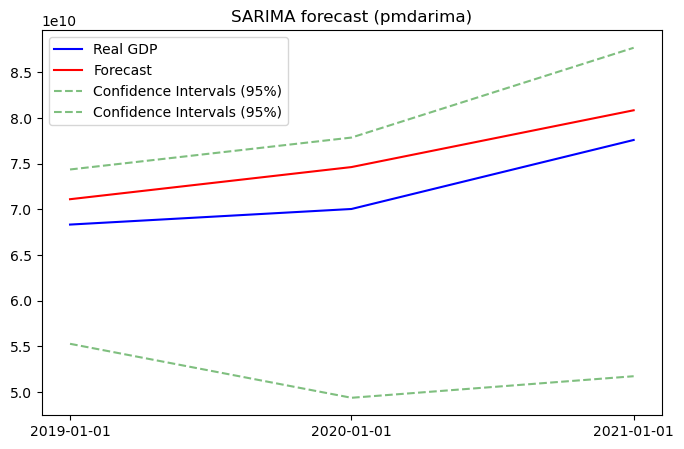

In [253]:
forecast, conf_int = as_model.predict(n_periods=3, return_conf_int=True, alpha=0.05)
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print()
print(as_model.summary())

plt.figure(figsize=(8,5))
plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    conf_int_df["lower_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    conf_int_df["upper_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("SARIMA forecast (pmdarima)")
plt.legend()

plt.show()

На модели SARIMA(2, 3, 2)x(1, 0, [], 9) удалось улучшить MAPE=0.0493, при ухудшении AIC=2640.482.  


Так как при первой итрации рассматривалась усеченная выборка (без первых двух значений), то критерий AIC на всех оптимальных моделях дал незначительно худший результат, но за счет того, что выборка стала больше на 3,5%, обощающие свойства моделей улучшились, что привело на одной из моделей - SARIMA(2, 3, 2)x(1, 0, [], 9) к улучшению метрики  MAPE.  

Также можно заметить, что впервые модель показала прогнозные значения больше чем реальные.

Датафрейм с промежуточными итогами:

In [254]:
model_results = [
    {'model':'MA(2)', 'MAPE':0.0985},
    {'model':'ARIMA(5, 3, 4)', 'MAPE':0.0638, 'AIC':2643.828},
    {'model':'ARIMA(4, 3, 1)', 'MAPE':0.0815, 'AIC':2647.817 },
    {'model':'SARIMA(2, 3, 2)x(1, 0, [], 9)', 'MAPE':0.0493, 'AIC':2640.482 }    
    ]

pd.DataFrame(model_results)

,model,MAPE,AIC
0,MA(2),0.0985,NaN
1,"ARIMA(5, 3, 4)",0.0638,2643.828
2,"ARIMA(4, 3, 1)",0.0815,2647.817
3,"SARIMA(2, 3, 2)x(1, 0, [], 9)",0.0493,2640.482


_______

Есть предположение, что интерполяция данных до квартального уровня поможет моделям ARIMA/SARIMA лучше построить прогноз, хотя новых данных не добавиться и в отсутсвии информации как наполняется ВВП в течение года,придется интерполировать линейно, возможно увеличение количества данных поможет построить более качественную модель.

In [255]:
train_df_interp = train_df.resample('QS').interpolate('linear')
train_df_interp.head(13)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1960-04-01,1.237745e+09
1960-07-01,1.258403e+09
1960-10-01,1.279062e+09
1961-01-01,1.299720e+09
1961-04-01,1.320378e+09
1961-07-01,1.341036e+09
1961-10-01,1.361695e+09
1962-01-01,1.382353e+09


ADF test results:
-2.9744644439940755
0.03734889627534032
8
223
{'1%': -3.460018927623594, '5%': -2.8745897386146817, '10%': -2.57372514086348}
9306.329558451163
d=1


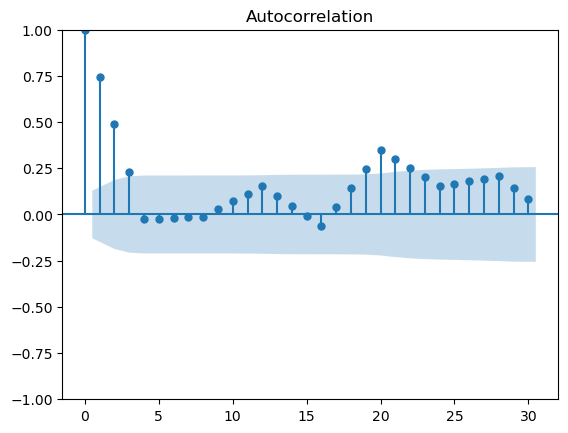

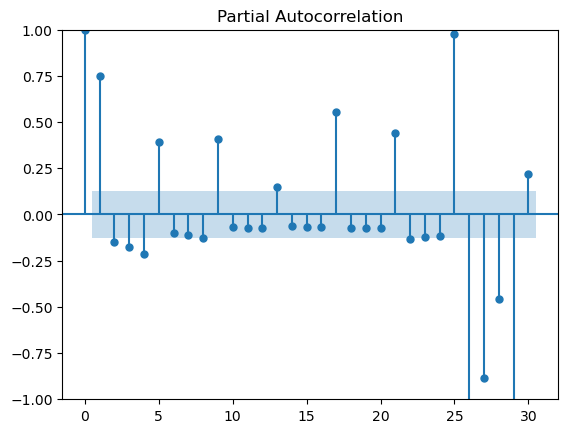

In [256]:
adf_acf_pacf(train_df_interp, lags=30)

Результат теста Дики-Фуллера при однократном диффернцировании меньше уровня значимости в 5%, но незначительно, посмотрим на результат при выборе уровня значимости в 1% и увеличим количество лагов для отображения на графиках автокорреляции.

ADF test results:
-8.769036770912104
2.55060313260643e-14
15
215
{'1%': -3.461136478222043, '5%': -2.875078880098608, '10%': -2.5739861168199027}
9219.249162658418
d=2


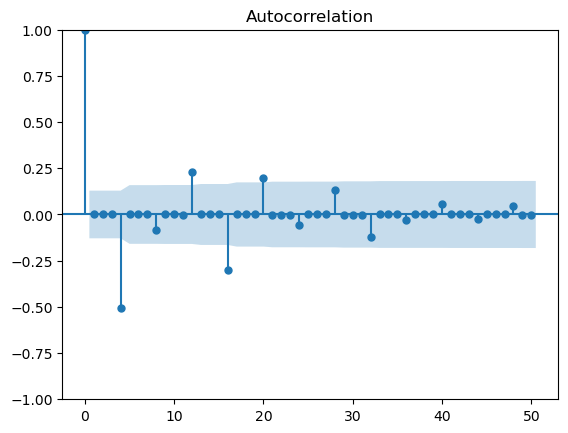

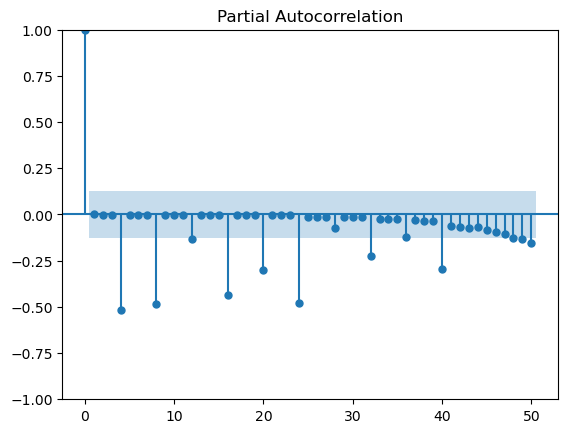

In [257]:
adf_acf_pacf(train_df_interp, critical_val='1%', lags=50)

При выборе уровня значимости в 1% стационарность достиагется при двойном дифференцировании, но при двойном дифференцировании, все значения полученные линейной интерполяцией будут обнуляться, так что для определения гиперпараметров будем пользоваться графиками с одной дфиффренциацией.  
Будем проверять следующие значения: d=1, q=[1,2,3,21,22,23,20], p=[1,5,9,25,30]

In [258]:
p_values = [1,5,9,25,30]  
d_values = [1]  
q_values = [1,2,3,21,22,23,20]

best_model = find_best_arima(train_df_interp, p_values, d_values, q_values)
forecast = best_model.forecast(steps=12)

Лучшая модель: ARIMA(30, 1, 1) с AIC=9911.527824184464


In [259]:
forecast = forecast.loc[test_df.index]
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print()
print(best_model.summary())

MAPE: 0.09023502097860349

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                  233
Model:                ARIMA(30, 1, 1)   Log Likelihood               -4923.764
Date:                Wed, 02 Oct 2024   AIC                           9911.528
Time:                        00:59:15   BIC                          10021.823
Sample:                    01-01-1960   HQIC                          9956.009
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3679     61.055      0.006      0.995    -119.298     120.034
ar.L2          0.6290     60.919      0.010      0.992    -118.771     120.029
ar.L3       -7.61e-05    

Улулчшения в метрике MAPE не произошло, проверим модель SARIMA с помощью автоматического подбора гиперпараметров

In [260]:
for m_ in [1,4,16,36]:
    as_model = auto_arima(train_df_interp,      
                        start_p=0,          
                        start_q=0,          
                        max_p=30,            
                        max_q=25,
                        d=1,
                        m=m_,
                        seasonal=True,      
                        trace=False,          
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)       


    print(f'm={m_}')
    forecast, conf_int = as_model.predict(n_periods=12, return_conf_int=True, alpha=0.05)
    forecast = forecast.loc[test_df.index]
    print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
    print(f'AIC:{as_model.aic()}')

m=1
MAPE: 0.03255802345998801
AIC:9953.431737485434
m=4
MAPE: 0.0454009929910306
AIC:9957.050415460191
m=16
MAPE: 0.056724785064553696
AIC:9951.888188126917
m=36
MAPE: 0.03255802345998801
AIC:9953.431737485434


Для сезонности  m=1 и m=36 получены одинаковые данные, что говорит об отсутствии сезонности и значит лучшая модель будет та, которая проще - ARIMA. Посмотрим на ее параметры.

In [261]:
as_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  233
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -4969.716
Date:                Wed, 02 Oct 2024   AIC                           9953.432
Time:                        01:17:05   BIC                           9977.559
Sample:                    01-01-1960   HQIC                          9963.162
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.097e+07   5.95e-09   1.36e+16      0.000     8.1e+07     8.1e+07
ar.L1          0.7175      0.374      1.918      0.055      -0.016       1.451
ma.L1          0.2739      0.367      0.745      0.456      -0.446       0.994
ma.L2          0.2668      0.349      0.764      0.445      -0.418       0.952
ma.L3          0.2598      0.332      0.783      0.433      -0.390       0.910
ma.L4         -0.6439      0.337     -1.913      0.056      -1.303       0.016
sigma2      2.755e+17   4.37e-17    6.3e+33      0.000    2.75e+17    2.75e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             28791.22
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              36.33   Skew:                             3.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+48. Standard errors may be unstable.
"""

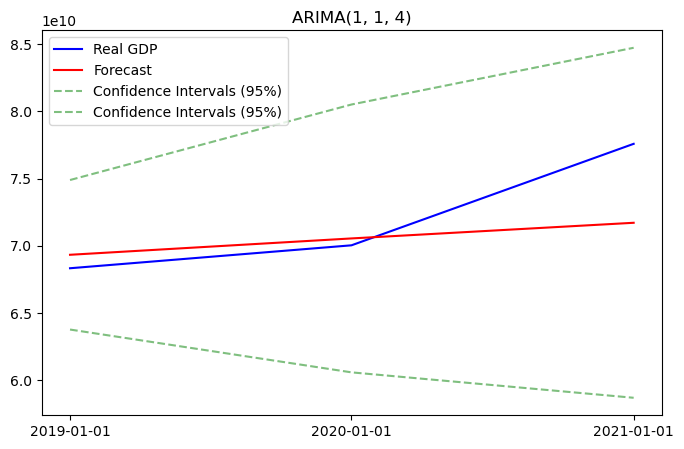

In [262]:
conf_int = conf_int[range(3,12,4)]
conf_int_df = pd.DataFrame(conf_int, index=test_df.index, columns=['lower_bound', 'upper_bound'])

plt.figure(figsize=(8,5))
plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    conf_int_df["lower_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    conf_int_df["upper_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("ARIMA(1, 1, 4)")
plt.legend()

plt.show()

С помощью upsampling и интерполяции данных до квартальных отметок удалось улучшить MAPE до 3,26%, такие результаты показала модель ARIMA(1, 1, 4).  
По графику также можно заметить, что реальные значения лежат в доверительном интервале, более резкий рост  ВВП в 2021 году также не был спрогнозирован моделью. 

_______

Второе предположение заключается в том, что с 2000 года по каким-то внешним факторам начался более резкий рост ВВП и вероятность того, что он вернется плавному к росту как с 1960 г. по 2000 г. мала. Тогда имеет смысл рассмотреть в качестве обучающей выборки ряд с 2000 г. с интерполированными значениями по кварталам.

In [263]:
train_df_interp = train_df_interp['2000-01-01':]

Что ряд не стационарен, мы уже знаем, но и двойное дифференццирование приведет линейно интерполированные значения к нулю, следовательно будем использовать d=1

In [264]:
for m_ in [1,2,4,8,36]:
    as_model = auto_arima(train_df_interp,      
                        start_p=0,          
                        start_q=0,          
                        max_p=30,            
                        max_q=25,
                        d=1,
                        m=m_,
                        seasonal=True,      
                        trace=False,          
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)       


    print(f'm={m_}')
    forecast, conf_int = as_model.predict(n_periods=12, return_conf_int=True, alpha=0.05)
    forecast = forecast.loc[test_df.index]
    conf_int = conf_int[range(3,12,4)]
    
    print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
    print(f'AIC:{as_model.aic()}')

m=1
MAPE: 0.036760336107043746
AIC:3188.86695337933
m=2
MAPE: 0.035855983604299944
AIC:3190.2630768053896
m=4
MAPE: 0.029083958928335634
AIC:3185.9499905144476
m=8
MAPE: 0.036760336107043746
AIC:3188.86695337933
m=36
MAPE: 0.036760336107043746
AIC:3188.86695337933


Модель с сезонностью в 4 квартала, т.е. в год, дала лучший результат MAPE=0.0291. Рассмотрим ее.

MAPE: 0.029083958928335634
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   73
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 4)   Log Likelihood               -1585.975
Date:                             Wed, 02 Oct 2024   AIC                           3185.950
Time:                                     01:20:35   BIC                           3201.887
Sample:                                 01-01-2000   HQIC                          3192.294
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.531e+08   3.46e-09   1.31e+17      0.000    4.53e+08    4.53e+08


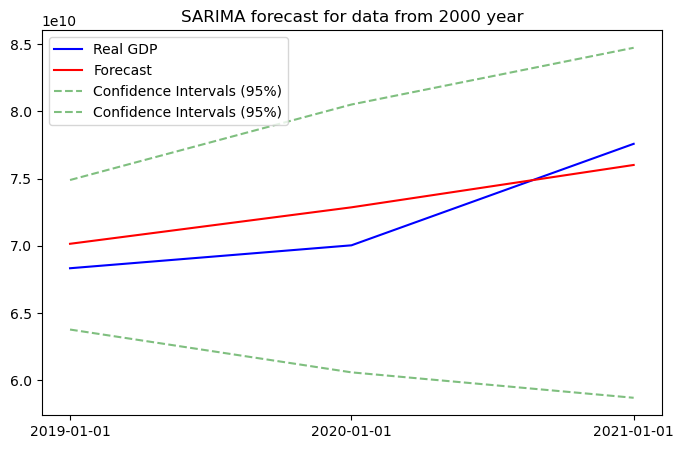

In [265]:
as_model = auto_arima(train_df_interp,      
                    start_p=0,          
                    start_q=0,          
                    max_p=30,            
                    max_q=25,
                    d=1,
                    m=4,
                    seasonal=True,      
                    trace=False,          
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=False)       


forecast, conf_int = as_model.predict(n_periods=12, return_conf_int=True, alpha=0.05)
forecast = forecast.loc[test_df.index]
conf_int = conf_int[range(3,12,4)]
    
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print(as_model.summary())

plt.figure(figsize=(8,5))
plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    conf_int_df["lower_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    conf_int_df["upper_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("SARIMA forecast for data from 2000 year")
plt.legend()

plt.show()   
      

С помощью upsampling и интерполяции данных до квартальных отметок и отсечения данных до 2000 года удалось улучшить MAPE до 2,91%, такие результаты показала модель SARIMAX(0, 1, 3)x(1, 0, [1], 4), которая для прогноза использует разницы в значениях и не использует авторегрессию, а учитывает только скользящуюю среднюю по последним трем ошибкам, при этом сезонность равна году, что наталкивает на мысль, что модель построенная на обычных годовых данных с 2000 года даст еще более точный прогноз.  
По графику также можно заметить, что реальные значения лежат в доверительном интервале, более резкий рост  ВВП в 2021 году также не был спрогнозирован моделью.

ADF test results:
-3.5191064690300133
0.007509745861275196
6
9
{'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}
421.17276786298123
d=3


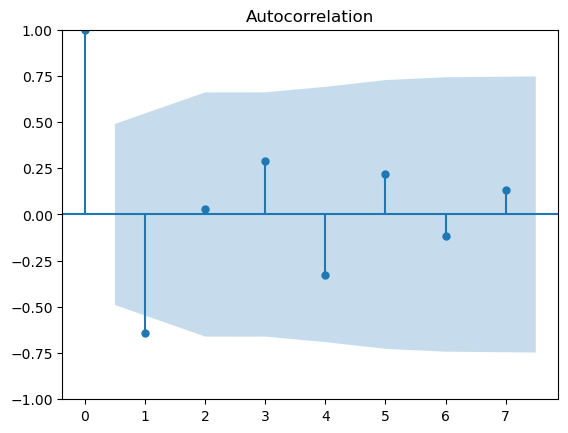

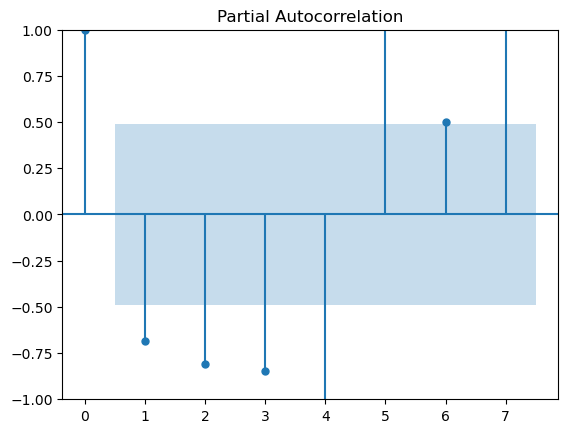

In [266]:
train_df_sliced = train_df['2000-01-01':]

adf_acf_pacf(train_df_sliced, lags=7)

In [267]:
for m_ in [1,2,3,4]:
    as_model = auto_arima(train_df_sliced,      
                        start_p=0,          
                        start_q=0,          
                        max_p=10,            
                        max_q=10,
                        d=3,
                        m=m_,
                        seasonal=True,      
                        trace=False,          
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)       


    print(f'm={m_}')
    forecast, conf_int = as_model.predict(n_periods=12, return_conf_int=True, alpha=0.05)
    forecast = forecast.loc[test_df.index]
        
    print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
    print(f'AIC:{as_model.aic()}')

m=1
MAPE: 0.026614176162562952
AIC:783.1975246191473
m=2
MAPE: 0.08074497864181429
AIC:706.4746396748659
m=3
MAPE: 0.13477821500207324
AIC:641.756579723174
m=4
MAPE: 0.026614176162562952
AIC:783.1975246191473


MAPE: 0.026614176162562952
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(0, 3, 3)   Log Likelihood                -387.599
Date:                Wed, 02 Oct 2024   AIC                            783.198
Time:                        01:20:54   BIC                            786.288
Sample:                    01-01-2000   HQIC                           783.356
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0805      0.520     -4.005      0.000      -3.099      -1.062
ma.L2          1.4114      0.912      1.548      0.122      -0.375       3.198
ma.L3         -0.2843    

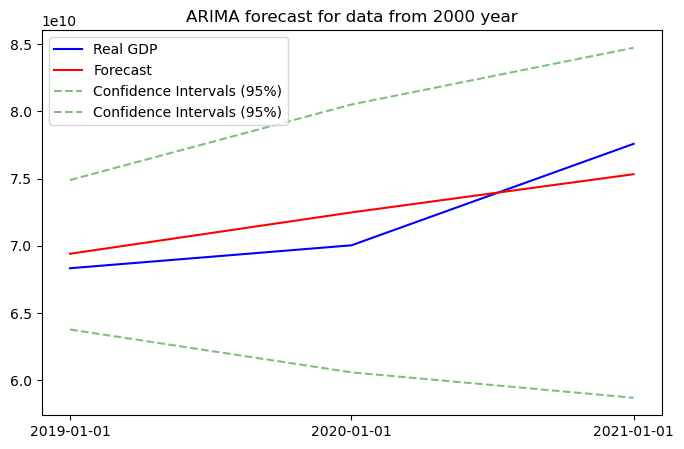

In [268]:
print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df, forecast)}')
print(as_model.summary())

plt.figure(figsize=(8,5))
plt.plot(test_df, color="blue", label="Real GDP")

plt.plot(forecast, color="red", label="Forecast")

plt.plot(
    conf_int_df["lower_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.plot(
    conf_int_df["upper_bound"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.5,
)

plt.xticks(test_df.index)
plt.title("ARIMA forecast for data from 2000 year")
plt.legend()

plt.show()   

С помощью отсечения данных до 2000 года удалось улучшить MAPE до 2,66%, такие результаты показала модель ARIMA(0, 3, 3), которая для прогноза использует разницы в значениях третьего порядка и не использует авторегрессию, а учитывает только скользящуюю среднюю по последним трем ошибкам.  
Такая модель как и модель скользящего среднего не сможет дать качественный долгосрочный прогоноз, но в условиях данной задачи и для тестовой выборки из 3 лет дала наименьший MAPE.
По графику также можно заметить, что реальные значения лежат в доверительном интервале, более резкий рост  ВВП в 2021 году также не был спрогнозирован моделью.

Промежуточный итог:

In [269]:
data_model_results = [
    {'data':'real','model':'SARIMA(2, 3, 2)x(1, 0, [], 9)', 'MAPE':0.0493},
    {'data':'quarterly_full','model':'ARIMA(1, 1, 4)', 'MAPE':0.0326},
    {'data':'quarterly_sliced','model':'SARIMAX(0, 1, 3)x(1, 0, [1], 4)', 'MAPE':0.0291},
    {'data':'real_sliced','model':'ARIMA(0, 3, 3)', 'MAPE':0.0266}    
    ]

pd.DataFrame(data_model_results)

,data,model,MAPE
0,real,"SARIMA(2, 3, 2)x(1, 0, [], 9)",0.0493
1,quarterly_full,"ARIMA(1, 1, 4)",0.0326
2,quarterly_sliced,"SARIMAX(0, 1, 3)x(1, 0, [1], 4)",0.0291
3,real_sliced,"ARIMA(0, 3, 3)",0.0266


________

### Волатильность. GARCH модель.

In [270]:
df_vol = df.pct_change(1).mul(100).abs()
df_vol.tail()

,GDP (current US$)
year,
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746
2020-01-01,2.495937
2021-01-01,10.780603


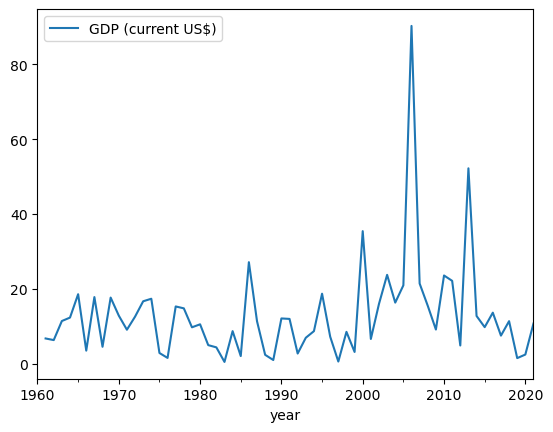

In [271]:
df_vol.plot()
plt.show()

In [272]:
split_test = df_vol.index[-3]
split_train = df_vol.index[-4]
train_df_vol = df_vol[:split_train]
test_df_vol = df_vol[split_test:]
print(f'Train shape: {train_df_vol.shape}, test shape: {test_df_vol.shape}')

Train shape: (59, 1), test shape: (3, 1)


ADF test results:
-6.725311059553777
3.4014596148856737e-09
0
57
{'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
382.739595975669
d=0


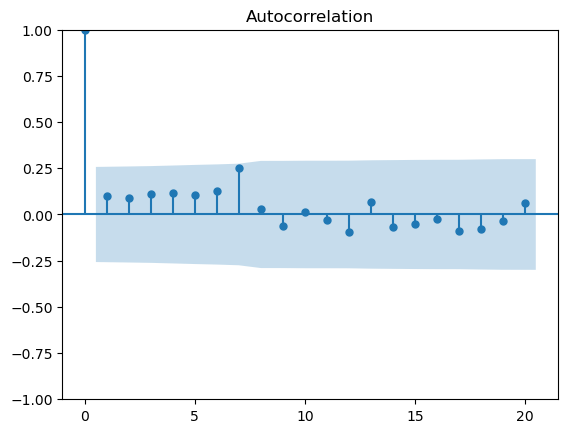

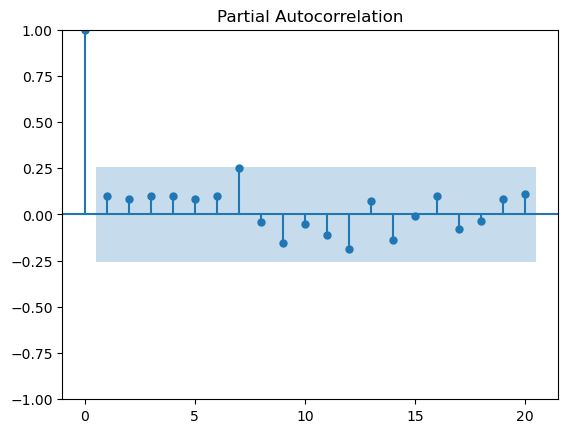

In [273]:
adf_acf_pacf(train_df_vol[1:])

Подберем лучшие гиперпараметры для модели GARCH перебором p и q от 1 до 7, сравнивать будем  по критериям AIC и BIC.

In [274]:
p_values = range(1,8)
q_values = range(1,8)

def find_best_garch(data, last_obs, p_values, q_values):
    """
    This function finds the best GARCH model by comparing different p and q parameters based on their AIC and BIC scores.
    It prints the best models based on AIC and BIC. Returns the two best models: by AIC and by BIC. 
    """
    best_aic = float('inf')
    best_bic = float('inf')
    best_order = None
    best_model = None
    
    for p in p_values:
        for q in q_values:
            try:
                
                model = arch_model(data, vol='Garch', p=p, q=q)
                model_fit = model.fit(last_obs=last_obs, disp='off')
                
                aic = model_fit.aic
                bic = model_fit.bic
                
                if aic < best_aic:
                    best_aic = aic
                    best_order_aic = (p, q)
                    best_model_aic = model_fit
                
                if bic < best_bic:
                    best_bic = bic
                    best_order_bic = (p, q)
                    best_model_bic = model_fit
                    
            except Exception as e:
                print(f"Ошибка для модели GARCH({p}, {q}): {e}")
                continue
    
    print(f'Лучшая модель по AIC: GARCH{best_order_aic} с AIC={best_aic}')
    print(f'Лучшая модель по BIC: GARCH{best_order_bic} с BIC={best_bic}')
    
    return best_model_aic, best_model_bic

# Подбор параметров для модели GARCH
best_model_aic, best_model_bic = find_best_garch(df_vol.dropna(), test_df_vol.index[1], p_values, q_values)


Лучшая модель по AIC: GARCH(6, 1) с AIC=455.7868104503139
Лучшая модель по BIC: GARCH(6, 1) с BIC=474.4846474454654


In [275]:
best_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      GDP (current US$)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -218.893
Distribution:                  Normal   AIC:                           455.787
Method:            Maximum Likelihood   BIC:                           474.485
                                        No. Observations:                   59
Date:                Wed, Oct 02 2024   Df Residuals:                       58
Time:                        01:20:59   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.7806      1.243      9.476  2.646e-21 [  9.344, 14.217]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         41.1212     13.272      3.098  1.946e-03      [ 15.109, 67.133]
alpha[1]   1.5090e-11  8.833e-03  1.708e-09      1.000 [-1.731e-02,1.731e-02]
alpha[2]   5.9737e-11  1.382e-02  4.324e-09      1.000 [-2.708e-02,2.708e-02]
alpha[3]   1.4378e-11  2.873e-02  5.004e-10      1.000 [-5.632e-02,5.632e-02]
alpha[4]   3.9215e-03  5.235e-03      0.749      0.454 [-6.340e-03,1.418e-02]
alpha[5]   1.4678e-11  8.959e-03  1.638e-09      1.000 [-1.756e-02,1.756e-02]
alpha[6]       0.7291      0.468      1.558      0.119      [ -0.188,  1.646]
beta[1]        0.0935  6.921e-02      1.351      0.177   [-4.218e-02,  0.229]
=============================================================================

Covariance estimator: robust
"""

MAPE: 42.50451546673401


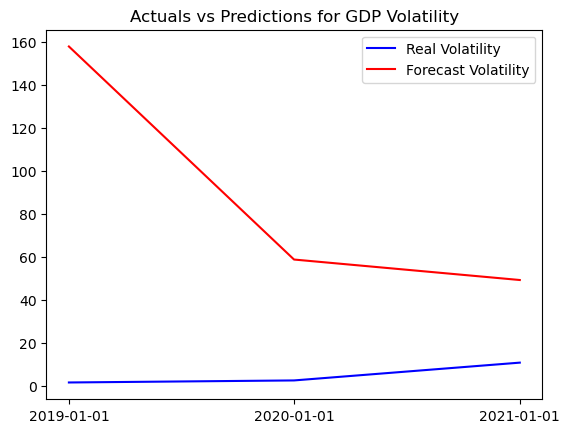

In [276]:
forecast_vol = best_model_aic.forecast().variance

print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df_vol, forecast_vol)}')

plt.plot(test_df_vol, color="blue", label="Real Volatility")
plt.plot(forecast_vol, color="red", label="Forecast Volatility")

plt.xticks(test_df_vol.index)
plt.title("Actuals vs Predictions for GDP Volatility")
plt.legend()

plt.show()



модель GARCH(6,1)не справилась с предсказанием волатильности, так как гиперпараметр p=6, получившийся в ходе настройки из-за большой волатильности в 2013 и в 2006 г берет лаг в 6 лет и увеличивает волатильность в 2019 г., хотя реальные значения небольшие. Попробуем сделать прогноз волатильности моделью ARCH, которая не будет учитывать ошибки и сравним результаты с моделью линейной регрессии с настройками по умолчанию.

Iteration:     10,   Func. Count:     91,   Neg. LLF: 229.29375174916743
Iteration:     20,   Func. Count:    190,   Neg. LLF: 223.82681018111435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.30832881686194
            Iterations: 27
            Function evaluations: 254
            Gradient evaluations: 27
MAPE: 19.908210675232983


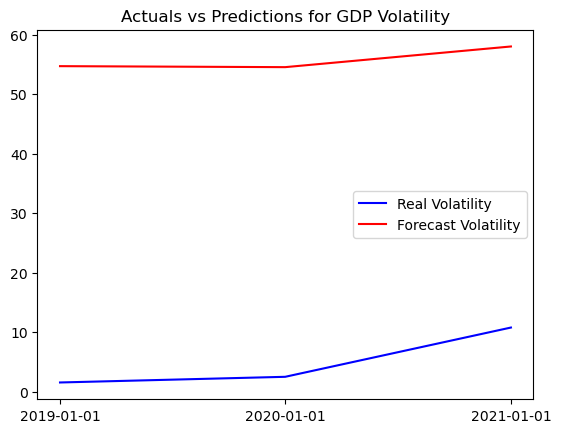

In [277]:
model = arch_model(df_vol.dropna(), vol='Arch', p=6)
model_fit = model.fit(last_obs=test_df_vol.index[1], update_freq=10)

model_fit.summary()
forecast_vol = model_fit.forecast().variance


print(f'MAPE: {metrics.mean_absolute_percentage_error(test_df_vol, forecast_vol)}')

plt.plot(test_df_vol, color="blue", label="Real Volatility")
plt.plot(forecast_vol, color="red", label="Forecast Volatility")

plt.xticks(test_df_vol.index)
plt.title("Actuals vs Predictions for GDP Volatility")
plt.legend()

plt.show()

Модель улучшила показатели, но все равно далека от реальных данных.

MAPE: 6.678132822200258


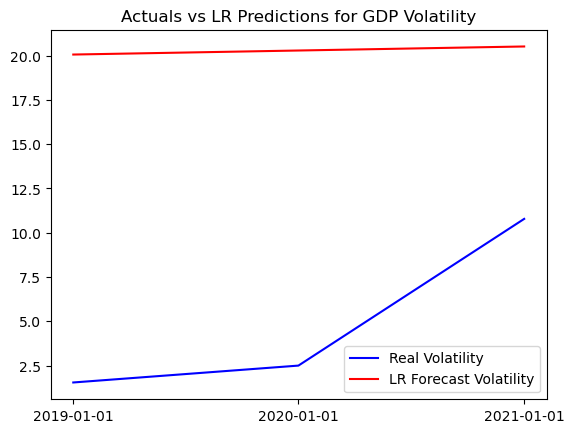

In [278]:
X_train = pd.DataFrame(range(df_vol.shape[0]))[
    : train_df_vol.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df_vol.shape[0]))[
    train_df_vol.shape[0] :
].fillna(0)
y_train = train_df_vol['GDP (current US$)'].fillna(0)
y_test = test_df_vol['GDP (current US$)'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, lr_predict)}')

plt.plot(y_test,color="blue", label="Real Volatility" )
plt.plot(pd.Series(lr_predict, index=y_test.index),color="red", label="LR Forecast Volatility")

plt.xticks(test_df_vol.index)
plt.title("Actuals vs LR Predictions for GDP Volatility")
plt.legend()

plt.show()

Линейная регрессия дала прогоноз волатильности лучшем, чем ARCH/GARH, но он все равно далек от реальных значений.

______

#### Prophet, ML модели

Построим прогноз моделью линейной регрессии с настройками по умолчанию.

In [279]:
df_ml = df.reset_index()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               62 non-null     datetime64[ns]
 1   GDP (current US$)  62 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [280]:
df_ml['year'] = pd.to_datetime(df_ml['year']).dt.year

train_df = df_ml[df_ml['year'] < 2019]
test_df = df_ml[df_ml['year'] >= 2019]

X_train = train_df['year'].values.reshape(-1, 1)
y_train = train_df['GDP (current US$)'].values

X_test = test_df['year'].values.reshape(-1, 1)
y_test = test_df['GDP (current US$)'].values

MAPE: 0.4749195340552572


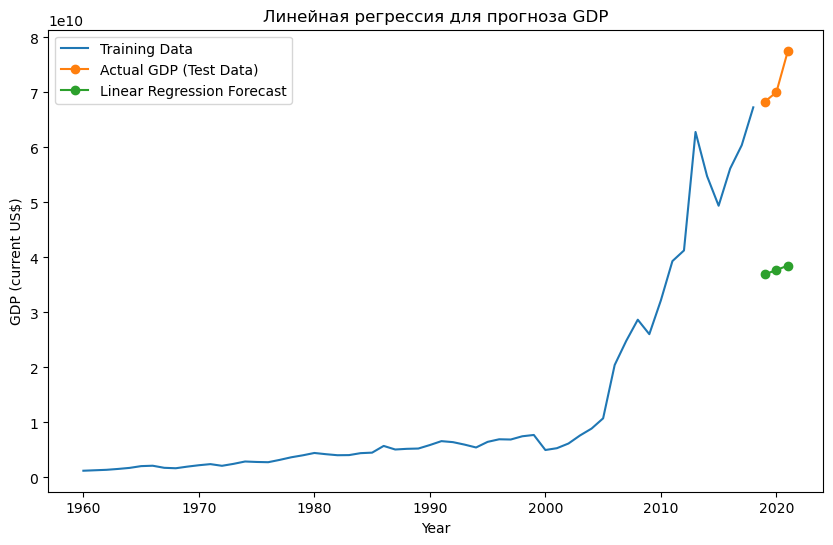

In [281]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred_lin)
print(f'MAPE: {mape}')

plt.figure(figsize=(10, 6))
plt.plot(train_df['year'], y_train, label='Training Data')
plt.plot(test_df['year'], y_test, label='Actual GDP (Test Data)', marker='o')
plt.plot(test_df['year'], y_pred_lin, label='Linear Regression Forecast', marker='o')
plt.title('Линейная регрессия для прогноза GDP')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.show()


Модель оинейной регресси дала очень слабый прогноз, MAPE - 0.4749.  

Проверим модель на усеченных данных с 2000 года.

MAPE: 0.02310561468948664


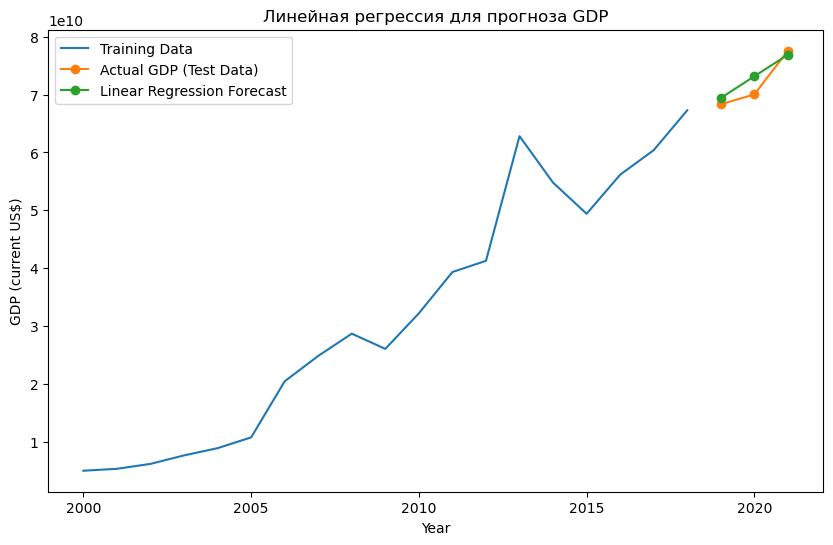

In [282]:
train_df = df_ml[(df_ml['year'] < 2019) & (df_ml['year'] >= 2000)]
test_df = df_ml[df_ml['year'] >= 2019]

X_train = train_df['year'].values.reshape(-1, 1)
y_train = train_df['GDP (current US$)'].values

X_test = test_df['year'].values.reshape(-1, 1)
y_test = test_df['GDP (current US$)'].values


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred_lin)
print(f'MAPE: {mape}')

plt.figure(figsize=(10, 6))
plt.plot(train_df['year'], y_train, label='Training Data')
plt.plot(test_df['year'], y_test, label='Actual GDP (Test Data)', marker='o')
plt.plot(test_df['year'], y_pred_lin, label='Linear Regression Forecast', marker='o')
plt.title('Линейная регрессия для прогноза GDP')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.show()

Прогноз получился достаточно точным: MAPE=0.0231, значения за 2019 и 2021 год довольны близки к реальным.

Построим модель полиномиальной линейно регрессии 3 порядка.

MAPE: 0.12483844458838927


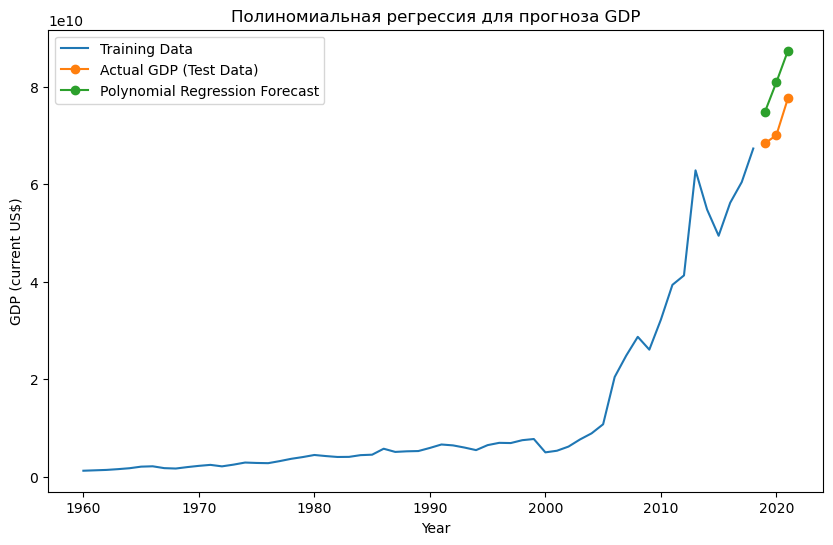

In [283]:
train_df = df_ml[df_ml['year'] < 2019]
test_df = df_ml[df_ml['year'] >= 2019]

X_train = train_df['year'].values.reshape(-1, 1)
y_train = train_df['GDP (current US$)'].values

X_test = test_df['year'].values.reshape(-1, 1)
y_test = test_df['GDP (current US$)'].values

poly = preprocessing.PolynomialFeatures(degree=3)

X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)

y_pred_poly = poly_reg.predict(X_poly_test)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred_poly)
print(f'MAPE: {mape}')


plt.figure(figsize=(10, 6))
plt.plot(train_df['year'], y_train, label='Training Data')
plt.plot(test_df['year'], y_test, label='Actual GDP (Test Data)', marker='o')
plt.plot(test_df['year'], y_pred_poly, label='Polynomial Regression Forecast', marker='o')
plt.title('Полиномиальная регрессия для прогноза GDP')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.show()


MAPE на полных данных 0.1248, модель спрогнозировала более высокие показатели ВВП, чем в тестовой выборке.  

Проверим ее на усеченной выборке.

MAPE: 0.1079925859927079


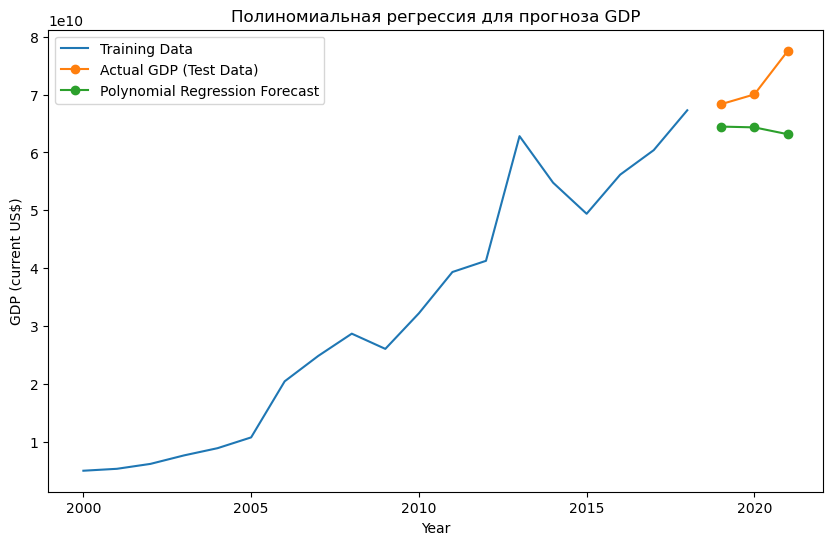

In [284]:
train_df = df_ml[(df_ml['year'] < 2019) & (df_ml['year'] >= 2000)]

X_train = train_df['year'].values.reshape(-1, 1)
y_train = train_df['GDP (current US$)'].values

poly = preprocessing.PolynomialFeatures(degree=3)

X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)

y_pred_poly = poly_reg.predict(X_poly_test)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred_poly)
print(f'MAPE: {mape}')


plt.figure(figsize=(10, 6))
plt.plot(train_df['year'], y_train, label='Training Data')
plt.plot(test_df['year'], y_test, label='Actual GDP (Test Data)', marker='o')
plt.plot(test_df['year'], y_pred_poly, label='Polynomial Regression Forecast', marker='o')
plt.title('Полиномиальная регрессия для прогноза GDP')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.show()

MAPE незначительно улучшилась 0,1080, но вместо роста было спрогнозировано падение ВВП.

Рассмотрим модель Prophet

In [285]:
df_pr = df.reset_index()
df_pr.columns = ['ds', 'y']


train_df = df_pr[df_pr['ds'] < '2019-01-01']
test_df = df_pr[df_pr['ds'] >= '2019-01-01']

In [286]:
model = Prophet()
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='YS')
forecast = model.predict(future)

forecast = forecast[forecast['ds'] >= '2019-01-01'][['ds', 'yhat']]

results = pd.merge(test_df, forecast, on='ds')

mape = metrics.mean_absolute_percentage_error(results['y'], results['yhat'])
print(f'MAPE: {mape}')

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\o_s8bf2i.json
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\ls_xtd1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\admin\\anaconda3\\envs\\MyEnv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=62922', 'data', 'file=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\o_s8bf2i.json', 'init=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\ls_xtd1a.json', 'output', 'file=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\prophet_modelmqqam6kr\\prophet_model-20241002012109.csv', '

MAPE: 0.4760461866353358


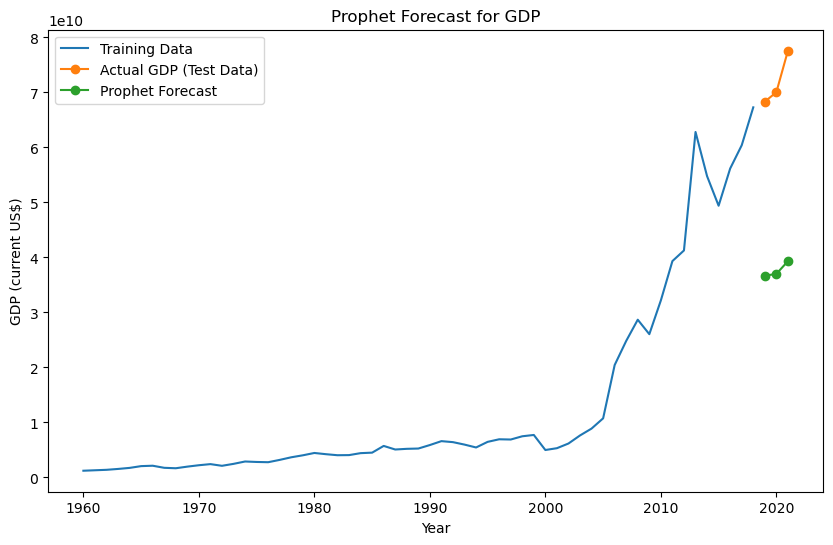

In [287]:
plt.figure(figsize=(10, 6))
plt.plot(train_df['ds'], train_df['y'], label='Training Data')
plt.plot(results['ds'], results['y'], label='Actual GDP (Test Data)', marker='o')
plt.plot(results['ds'], results['yhat'], label='Prophet Forecast', marker='o')
plt.title('Prophet Forecast for GDP')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.show()

Как и модель линейной регрессии модель Prophet не дала адекватного прогноза на полных данных, попробуем ее усеченных данных.

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\gq0gkh_z.json
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\tyxppvif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\admin\\anaconda3\\envs\\MyEnv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=59242', 'data', 'file=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\gq0gkh_z.json', 'init=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\tyxppvif.json', 'output', 'file=C:\\Users\\admin\\AppData\\Local\\Tem

MAPE: 0.01439958161027012


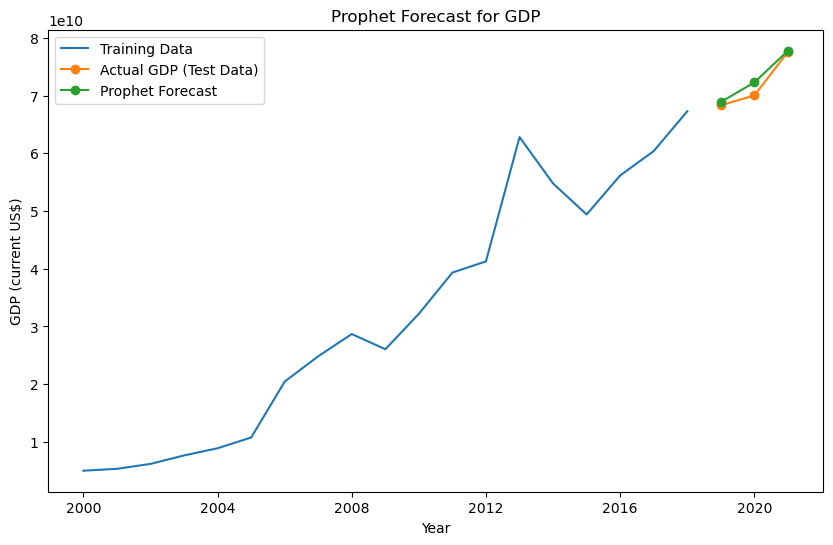

In [288]:
train_df = df_pr[(df_pr['ds'] < '2019-01-01') & (df_pr['ds'] >= '2000-01-01')]

model = Prophet()
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='YS')
forecast = model.predict(future)

forecast = forecast[forecast['ds'] >= '2019-01-01'][['ds', 'yhat']]

results = pd.merge(test_df, forecast, on='ds')

mape = metrics.mean_absolute_percentage_error(results['y'], results['yhat'])
print(f'MAPE: {mape}')


plt.figure(figsize=(10, 6))
plt.plot(train_df['ds'], train_df['y'], label='Training Data')
plt.plot(results['ds'], results['y'], label='Actual GDP (Test Data)', marker='o')
plt.plot(results['ds'], results['yhat'], label='Prophet Forecast', marker='o')
plt.title('Prophet Forecast for GDP')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.legend()
plt.show()

На данных с 2020 года модель Prophet дала лучший из полученных MAPE=0.0144, предсказания модели выше реальных но совсем незначительно, особенно в 2019 и 2021 г.  

Подведем итоги в табличке.

In [289]:
data_ml_results = [
    {'data':'real','model':'linear_reg', 'MAPE':0.4743},
    {'data':'real','model':'poly_linear_reg(3)', 'MAPE':0.1260},
    {'data':'real','model':'Prophet', 'MAPE':0.4754},
    {'data':'real_sliced','model':'linear_reg', 'MAPE':0.0231},
    {'data':'real_sliced','model':'poly_linear_reg(3)', 'MAPE':0.1080},
    {'data':'real_sliced','model':'Prophet', 'MAPE':0.0144} 
    ]

pd.DataFrame(data_ml_results)

,data,model,MAPE
0,real,linear_reg,0.4743
1,real,poly_linear_reg(3),0.1260
2,real,Prophet,0.4754
3,real_sliced,linear_reg,0.0231
4,real_sliced,poly_linear_reg(3),0.1080
5,real_sliced,Prophet,0.0144


Модель Prophet показала наилучшую метрику MAPE на данных с 2000 года, также стоит отметить, что на полных данных лучше отработала модель полиномиальной линейной регрессии.

______________

Слишком большая разница в предсказаниях линейной регрессии и модели Prophet на полных данных и усеченных наталкивает на мысль, что данные для предсказания "устаривают", и тогда задача должна состоять в поиске оптимального окна от даты тестовой выборке, на которой будет обучаться модель.  
Ведь отсечение данных с 2000 года было сделано только из анализа графика данных, предположим что это было не оптимальное отсечение тогда, оптимальное можно подобрать для каждой модели перебором GridSearch или RandomSearch, так как объем данный достаточно маленький. Но если объем данных будет большой перебор будет ресурсозатратным, тогда вероятно можно будет воспользоваться библиотеками оптимизации.  

Попробуем найти оптимальный размер обучающей выборки с помощью библиотеки Optuna для моделей показавших лучшие результаты в исследовании: линейной регрессии, Prophet и ARIMA(0,3,3).

In [290]:
import logging
import optuna

logging.getLogger("optuna").setLevel(logging.WARNING)

Линейная регрессия

In [291]:
def objective(trial):
    """Optuna objective function for looking for best train_df size for Linear regression.
    """
    train_size = trial.suggest_int('train_size', 10, len(df_ml) - 3) 
    
    model = LinearRegression()
    
    train = df_ml.iloc[-(train_size + 3):-3] 
    test = df_ml.iloc[-3:]  
    
    model.fit(train[['year']], train['GDP (current US$)'])
    
    predictions = model.predict(test[['year']])

    mape = metrics.mean_absolute_percentage_error(test['GDP (current US$)'], predictions)
    

    return mape
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50,)

print(f"Best size: {study.best_trial.params['train_size']}")
print(f"Best MAPE: {study.best_trial.value}")

Best size: 20
Best MAPE: 0.0190405734946746


Prophet

In [292]:
def objective(trial):
    """Optuna objective function for looking for best train_df size for Prophet.
    """
    train_size = trial.suggest_int('train_size', 10, len(df_pr) - 3) 
    
    train = df_pr.iloc[-(train_size + 3):-3]
    test = df_pr.iloc[-3:]
    
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=3, freq='Y')
    forecast = model.predict(future)
    
    predicted = forecast[['ds', 'yhat']].tail(3)

    mape = metrics.mean_absolute_percentage_error(test['y'], predicted['yhat'])
    

    return mape
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50,)

print(f"Best size: {study.best_trial.params['train_size']}")
print(f"Best MAPE: {study.best_trial.value}")

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\3m52ko_e.json
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\zqkfgl_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\admin\\anaconda3\\envs\\MyEnv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=40816', 'data', 'file=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\3m52ko_e.json', 'init=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\zqkfgl_c.json', 'output', 'file=C:\\Users\\admin\\AppData\\Local\\Temp

Best size: 15
Best MAPE: 0.00819481765373439


ARIMA(0,3,3)

In [293]:
def objective(trial):
    """Optuna objective function for looking for best train_df size for ARIMA(0,3,3).
    """
    train_size = trial.suggest_int('train_size', 10, len(df) - 3)
    
    train = df.iloc[-(train_size + 3):-3]
    test = df.iloc[-3:]
    
    try:
        model = ARIMA(train['GDP (current US$)'], order=(0, 3, 3))
        model_fit = model.fit()
        
        forecast = model_fit.forecast(steps=3)
        
        mape = metrics.mean_absolute_percentage_error(test['GDP (current US$)'], forecast)
        
        return mape
    except:
        return float('inf')
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50,)

print(f"Best size: {study.best_trial.params['train_size']}")
print(f"Best MAPE: {study.best_trial.value}")

Best size: 16
Best MAPE: 0.023418910363997583


Благодаря подбору оптимального размера обучающей выборки метрики по всем моделям были улучшены, при этом метрика MAPE модели Prophet показала дучший результат - 0,0082.  
Запишем результаты в виде таблицы.

In [301]:
size_model_results = [
    {'model':'Linear_reg', 'MAPE':0.0190, 'train_size':20},
    {'model':'ARIMA(0,3,3)', 'MAPE':0.0234, 'train_size':16},
    {'model':'Prophet', 'MAPE':0.0082,'train_size':15}
    ]

pd.DataFrame(size_model_results)

,model,MAPE,train_size
0,Linear_reg,0.0190,20
1,"ARIMA(0,3,3)",0.0234,16
2,Prophet,0.0082,15


_____

Так как данные тестовой выборки были использованы как валидационные, интересно будет испытать модели на новых тестовых данных, для этого можно взять данные на [сайте worldbank.org](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=GH). (данные за 2021 год немного другие).  

Отложим ВВП за 2022 г.и 2023 г. в тестовую выборку, а обучающуюю построим для трех ранее отобранных моделей на выбранных для них оптимальных размерах.

In [294]:
df_new = pd.read_csv("data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_31795.csv", skiprows=4)

In [295]:
df_new = df_new[df_new['Country Name'] == 'Ghana']
df_new = df_new.drop(df_new.columns[:4], axis=1)
df_new = df_new.drop(df_new.columns[-1], axis=1)
df_new = df_new.T

df_new = df_new.rename(columns={83: 'GDP (current US$)'})
df_new.index= pd.to_datetime(df_new.index, format='%Y')
df_new.tail()

,GDP (current US$)
2019-01-01,6.833797e+10
2020-01-01,7.004310e+10
2021-01-01,7.952442e+10
2022-01-01,7.426336e+10
2023-01-01,7.637039e+10


In [296]:
train_size = 16
train = df_new.iloc[-(16 + 2):-2]  # последние train_size данных перед тестом
test = df_new.iloc[-2:]  # последние 3 года как тест

model = ARIMA(train['GDP (current US$)'], order=(0, 3, 3))
model_fit = model.fit()

forecast = model_fit.forecast(steps=2)
mape = metrics.mean_absolute_percentage_error(test['GDP (current US$)'], forecast)
print(f"ARIMA MAPE: {mape}")

ARIMA MAPE: 0.037420662099314966


In [297]:
df_new_ml = df_new.reset_index()
df_new_ml['index'] = pd.to_datetime(df_new_ml['index']).dt.year

model = LinearRegression()
    
train_size = 20
train = df_new_ml.iloc[-(train_size + 2):-2]  # последние `train_size` данных перед тестом
test = df_new_ml.iloc[-2:]  # последние 3 года как тест
    
model.fit(train[['index']], train['GDP (current US$)'])
    
predictions = model.predict(test[['index']])
mape = metrics.mean_absolute_percentage_error(test['GDP (current US$)'], predictions)
print(f"Linear Regression MAPE: {mape}")

Linear Regression MAPE: 0.11016305012013047


In [298]:
df_new_pr = df_new.reset_index()
df_new_pr.columns = ['ds', 'y']

train_size = 15
train = df_new_pr.iloc[-(train_size + 2):-2]  
test = df_new_pr.iloc[-2:]  
    
model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=2, freq='Y')
forecast_ = model.predict(future)
    
predicted = forecast_[['ds', 'yhat']].tail(2)
    
mape = metrics.mean_absolute_percentage_error(test['y'], predicted['yhat'])
print(f"Prophet MAPE: {mape}")

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\0soxjx_6.json
DEBUG:cmdstanpy:input tempfile: C:\Users\admin\AppData\Local\Temp\tmphgzqapmw\hljihhgi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\admin\\anaconda3\\envs\\MyEnv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=74956', 'data', 'file=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\0soxjx_6.json', 'init=C:\\Users\\admin\\AppData\\Local\\Temp\\tmphgzqapmw\\hljihhgi.json', 'output', 'file=C:\\Users\\admin\\AppData\\Local\\Tem

Prophet MAPE: 0.04182292816983561


Выведем тестовый результат в таблицу вместе с предсказанными значениями.

In [299]:
test_results = [
    test['y'].values,
    forecast.values,
    predictions,
    predicted['yhat'].values
    ]

results_df = pd.DataFrame(test_results, 
                          columns=['2022', '2023'], 
                          index=['Real_GDP', 'ARIMA', 'Linear Reg', 'Prophet']
                          )


pd.concat([results_df, 
           pd.DataFrame([[np.NaN, 0.0374, 0.1102, 0.0418],
                         [np.NaN, 16, 20, 15]],
                        index=['MAPE','Train size'],
                        columns=['Real_GDP', 'ARIMA', 'Linear Reg', 'Prophet']
                        ).T
           ], axis=1
          )

,2022,2023,MAPE,Train size
Real_GDP,7.426336e+10,7.637039e+10,NaN,NaN
ARIMA,7.706237e+10,7.920764e+10,0.0374,16.0
Linear Reg,8.167709e+10,8.557271e+10,0.1102,20.0
Prophet,7.682903e+10,8.012000e+10,0.0418,15.0


Линейная регрессия хуже всего справилась с прогнозом:  MAPE - 11% и  модель не смогла предугадать снижение ВВП в 2022 году, в отличие от моделей Prophet и ARIMA, которые смогли спрогнозировать уменьшение ВВП в 2022 г. и повышение 2023 г., но ближе к прогнозу оказалась модель ARIMA - MAPE=0,0374.

_____

Итоги: 
 
- Проведен анализ данных о ВВП Ганы с 1960 по 2021 год.  
- Произведены прогнозы моделями: MA, ARIMA/SARIMA, Linear Regression, Prophet.  
- Модели были построены на реальных данных, upsample данных(расширенных до квартала) и на усеченных данных.  
- Также выполен подбор оптимального размера обучающей выборки для моделей, показавших лучшие метрики.  
- Выбор модели и гиперпараметров произведен на валидационной выборке.  
- Финальные результаты метрики определены на тестовом наборе, взятом из открытых источников (2022 г., 2023 г.).  

Для оценки качества прогнозов использовалась метрика MAPE (Mean Absolute Percentage Error).  


По резултатам исследования для краткосрочного прогноза лучше себя проявили модели Prophet и ARIMA(0,3,3).

